In [1]:
import gzip
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import sys

sys.path.append('../modules')
tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[1], 'GPU')

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
#Open file
#filepath = '/work/friemer/hgcalml/SimpleCocoa/analyseSimpleCocoa/analysisoutput'
filepath = '/work/friemer/hgcalml/CocoaTotalEnergyQmin01PhiEta/analysisoutput'
filepath = '/work/friemer/hgcalml/analysisoutputoldmatching'

# Open the file and load the data
with gzip.open(filepath, 'rb') as input_file:
    analysis_data = pickle.load(input_file)
    
# Print the keys of the data
print('Analysis data keys:', analysis_data.keys())
print('shower keys ',analysis_data['showers_dataframe'].keys())
print('events',analysis_data['events_dataframe'])
print('scalar keys',analysis_data['scalar_variables'].keys())
#print(analysis_data['alpha_ids'])
#print(analysis_data['noise_masks'])
#print(analysis_data['matched'])
print('matched keys',analysis_data['matched_showers'].keys())
print('processed keys',analysis_data['processed_dataframe'].keys())
print('features list keys', analysis_data['features'][0].keys())
print('truth list keys', analysis_data['truth'][0].keys())
print('prediction list keys', analysis_data['prediction'][0].keys())

df = analysis_data['showers_dataframe']
t_list = analysis_data['truth']
pred_list = analysis_data['prediction']
proc_df = analysis_data['processed_dataframe']

2024-07-12 12:37:33.447415: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-12 12:37:35.195685: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11473 MB memory:  -> device: 1, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:03:00.0, compute capability: 5.2


Analysis data keys: dict_keys(['showers_dataframe', 'events_dataframe', 'scalar_variables', 'alpha_ids', 'noise_masks', 'matched', 'matched_showers', 'processed_dataframe', 'features', 'truth', 'prediction'])
shower keys  Index(['t_rec_energy', 'pred_energy_unc', 'pred_sid', 'pred_energy_tracks_raw',
       'pred_no_minbias_fraction', 'truthHitAssignedEnergies', 'pred_energy',
       'pred_energy_hits_raw', 'pred_energy_hits_corrected',
       'pred_energy_high_quantile', 'pred_time', 'truthHitAssignedY',
       'pred_energy_tracks_corrected', 'truthHitAssignedZ', 'pred_ccoords',
       'truthHitAssignedEta', 'truthHitAssignedPIDs', 'truthHitAssignementIdx',
       'truthHitAssignedX', 'truthHitSpectatorFlag', 'pred_pos',
       'truthHitAssignedT', 'pred_energy_low_quantile',
       'truthHitFullyContainedFlag', 'truthHitAssignedPhi', 'pred_id',
       'pred_dist', 'no_noise_sel', 'pred_energy_corr_factor', 'event_id'],
      dtype='object')
events None
scalar keys dict_keys(['beta_th

## Neutral Efficiency, Fakerate, p

/tmp/ipykernel_420976/3249749180.py:47: RuntimeWarning: invalid value encountered in long_scalars
  fake_rate.append(np.sum(faked[mask_PID_pred]) / np.sum(mask_binpred[mask_PID_pred]))
/tmp/ipykernel_420976/3249749180.py:49: RuntimeWarning: invalid value encountered in long_scalars
  corr_class_prob.append(np.sum(matched[mask_PID_matched]) / np.sum(mask_bintruth[mask_PID_matched]))
/tmp/ipykernel_420976/3249749180.py:46: RuntimeWarning: invalid value encountered in long_scalars
  efficiencies.append(np.sum(matched[mask_PID_truth]) / np.sum(mask_bintruth[mask_PID_truth]))
/usr/local/lib/python3.8/dist-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


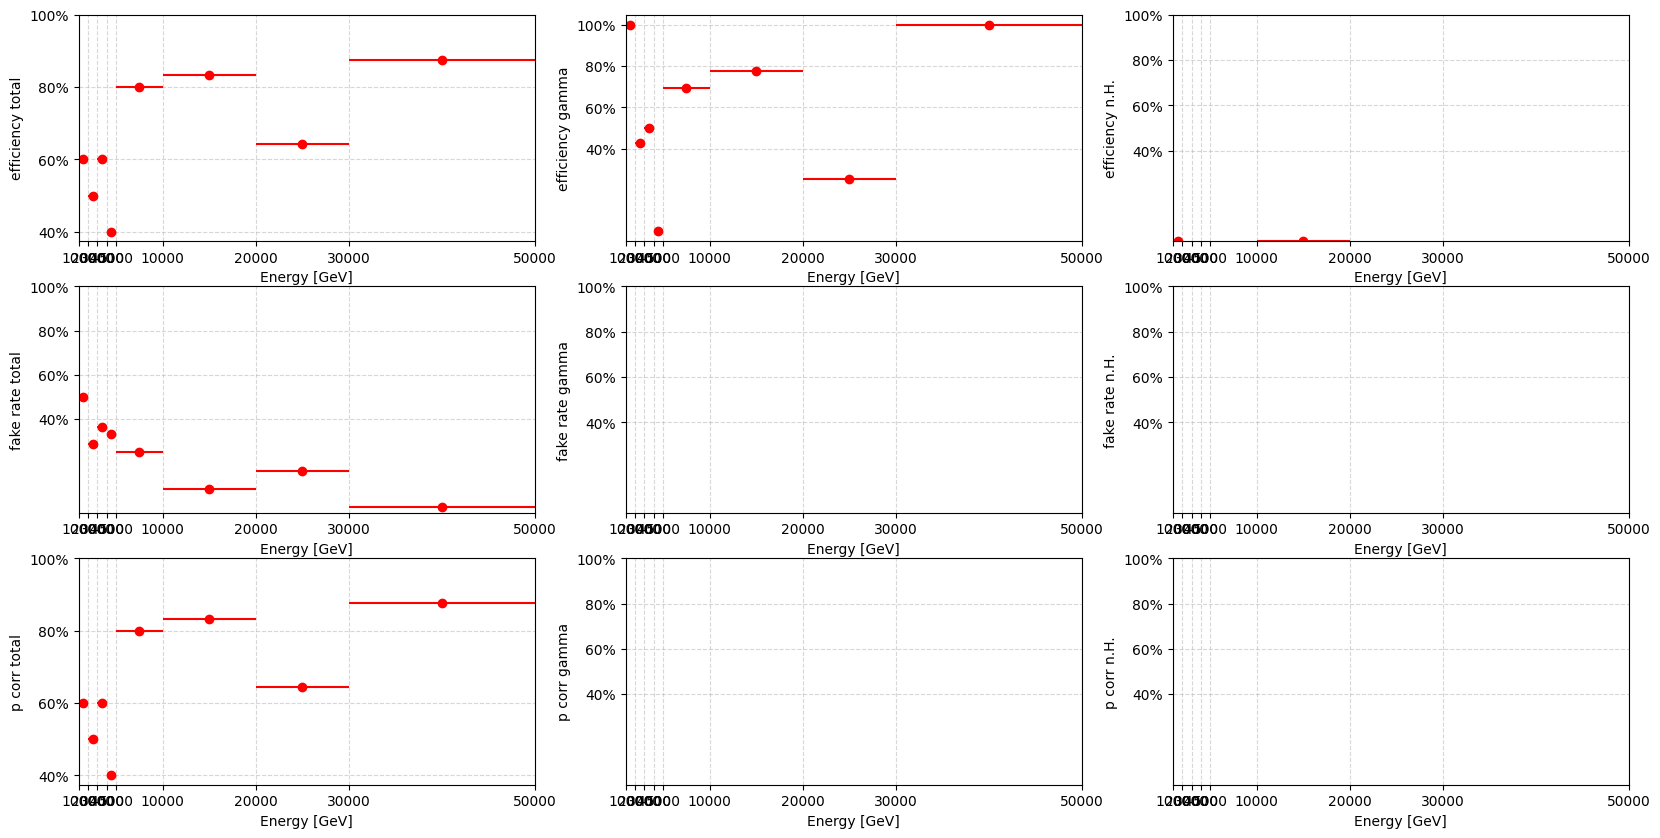

In [6]:
def help_calc_efficiencies(df, bins, mask=None):
    n_trues = []
    n_pred = []
    n_fakes = []
    n_matched = []
    efficiencies = []
    fake_rate = []
    corr_class_prob = []
    mask_predicted = np.isnan(df['pred_energy']) == False
    mask_truth = np.isnan(df['truthHitAssignedEnergies']) == False
    
    if mask == None:
        mask_PID_truth = np.ones(len(df), dtype=bool)
        mask_PID_pred = mask_PID_truth
    else:
        if(mask == 0):
            mask_PID_truth = df['truthHitAssignedPIDs'].isin([22])
        elif(mask == 1):
            mask_PID_truth = df['truthHitAssignedPIDs'].isin([130,310,311,2112,-2112,3122,-3122,3322,-3322])
        else:
            raise ValueError("mask must be 0 or 1")
        
        mask_PID_pred = df['pred_id'].isin([mask])
    mask_PID_matched = np.logical_and(mask_PID_truth, mask_PID_pred)
        
    
    for i in range(len(bins) - 1):
        mask_bintruth = np.logical_and(
            df['truthHitAssignedEnergies'] >= bins[i],
            df['truthHitAssignedEnergies'] < bins[i + 1])
        n_trues.append(np.sum(mask_bintruth))
        mask_binpred = np.logical_and(
            df['pred_energy'] >= bins[i],
            df['pred_energy'] < bins[i + 1])
        n_pred.append(np.sum(mask_binpred))

        matched = np.logical_and(
            mask_predicted,
            mask_bintruth)
        n_matched.append(np.sum(matched))
        faked = np.logical_and(
            mask_binpred,
            np.logical_not(mask_truth))
        n_fakes.append(np.sum(faked))

        efficiencies.append(np.sum(matched[mask_PID_truth]) / np.sum(mask_bintruth[mask_PID_truth]))
        fake_rate.append(np.sum(faked[mask_PID_pred]) / np.sum(mask_binpred[mask_PID_pred]))
        
        corr_class_prob.append(np.sum(matched[mask_PID_matched]) / np.sum(mask_bintruth[mask_PID_matched]))
    return np.array(n_trues), np.array(n_pred), np.array(n_matched), np.array(n_fakes), np.array(efficiencies), np.array(fake_rate), np.array(corr_class_prob)
def efficiency_plots(df, bins):
    # Calculate the bin positions and widths
    binwidth = bins[1:] - bins[:-1]
    x_pos = bins[:-1] + binwidth / 2
    x_err = binwidth / 2
    
    # Calculate the efficiencies and fake rates for the total
    n_trues, n_pred, n_matched, n_fakes, efficiencies, fake_rate, corr_class_prob= help_calc_efficiencies(df, bins)
    
    y_eff = efficiencies *100
    yerr_eff = np.sqrt(efficiencies * (1 - efficiencies) / n_trues)
    
    y_fake = fake_rate *100
    yerr_fake = np.sqrt(fake_rate * (1 - fake_rate) / n_pred)
    
    y_corr = corr_class_prob*100
    yerr_corr = np.sqrt(corr_class_prob * (1 - corr_class_prob) / n_trues)
    
    # Calculate the efficiencies and fake rates for the photons
    n_trues_photon, n_pred_photon, n_matched_photon, n_fakes_photon, efficiencies_photon, \
    fake_rate_photon, corr_class_prob_photon = help_calc_efficiencies(df, bins,0)
    
    
    y_eff_photon = efficiencies_photon*100
    yerr_eff_photon = np.sqrt(efficiencies_photon * (1 - efficiencies_photon) / n_trues_photon)
    
    y_fake_photon = fake_rate_photon*100
    yerr_fake_photon = np.sqrt(fake_rate_photon * (1 - fake_rate_photon) / n_pred_photon)
    
    y_corr_photon = corr_class_prob_photon*100
    yerr_corr_photon = np.sqrt(corr_class_prob_photon * (1 - corr_class_prob_photon) / n_trues_photon)
    
    # Calculate the efficiencies and fake rates for the neutral hadrons
    #130: "K0L", 310: "K0S", 311: "K0", 2112: "neutron",-2112: "antineutron",3122: "Lambda",-3122: "antilambda"3322: "Xi0",-3322: "antixi0"
    
    n_trues_neutral_hadrons, n_pred_neutral_hadrons, n_matched_neutral_hadrons, \
    n_fakes_neutral_hadrons, efficiencies_neutral_hadrons, fake_rate_neutral_hadrons, corr_class_prob_neutral_hadrons \
    = help_calc_efficiencies(df, bins, 1)
    
    y_eff_neutral_hadrons = efficiencies_neutral_hadrons*100
    yerr_eff_neutral_hadrons = np.sqrt(efficiencies_neutral_hadrons * (1 - efficiencies_neutral_hadrons) / n_trues_neutral_hadrons)
    
    y_fake_neutral_hadrons = fake_rate_neutral_hadrons*100
    yerr_fake_neutral_hadrons = np.sqrt(fake_rate_neutral_hadrons * (1 - fake_rate_neutral_hadrons) / n_pred_neutral_hadrons)
    
    y_corr_neutral_hadrons = corr_class_prob_neutral_hadrons*100
    yerr_corr_neutral_hadrons = np.sqrt(corr_class_prob_neutral_hadrons * (1 - corr_class_prob_neutral_hadrons) / n_trues_neutral_hadrons)
    
    # Create the plots
    fig, ((ax1, ax2, ax3), (ax4, ax5,ax6), (ax7,ax8,ax9)) = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))
    ax1.errorbar(x_pos, y_eff, xerr=x_err, yerr=yerr_eff, fmt='o', color='red', label='Efficiency')
    ax1.set_ylabel('efficiency total', fontsize=10)
    ax2.errorbar(x_pos, y_eff_photon, xerr=x_err, yerr=yerr_eff_photon, fmt='o', color='red', label='Efficiency')
    ax2.set_ylabel('efficiency gamma', fontsize=10)
    ax3.errorbar(x_pos, y_eff_neutral_hadrons, xerr=x_err, yerr=yerr_eff_neutral_hadrons, fmt='o', color='red', label='Efficiency')
    ax3.set_ylabel('efficiency n.H.', fontsize=10)
    
    ax4.errorbar(x_pos, y_fake, xerr=x_err, yerr=yerr_fake, fmt='o', color='red', label='Fake rate')
    ax4.set_ylabel('fake rate total', fontsize=10)
    ax5.errorbar(x_pos, y_fake_photon, xerr=x_err, yerr=yerr_fake_photon, fmt='o', color='red', label='Fake rate')
    ax5.set_ylabel('fake rate gamma', fontsize=10)
    ax6.errorbar(x_pos, y_fake_neutral_hadrons, xerr=x_err, yerr=yerr_fake_neutral_hadrons, fmt='o', color='red', label='Fake rate')
    ax6.set_ylabel('fake rate n.H.', fontsize=10)
    
    ax7.errorbar(x_pos, y_corr, xerr=x_err, yerr=yerr_corr, fmt='o', color='red', label='probability of correct class')
    ax7.set_ylabel('p corr total', fontsize=10)
    ax8.errorbar(x_pos, y_corr_photon, xerr=x_err, yerr=yerr_corr_photon, fmt='o', color='red', label='probability of correct class')
    ax8.set_ylabel('p corr gamma', fontsize=10)
    ax9.errorbar(x_pos, y_corr_neutral_hadrons, xerr=x_err, yerr=yerr_corr_neutral_hadrons, fmt='o', color='red', label='probability of correct class')
    ax9.set_ylabel('p corr n.H.', fontsize=10)

    for ax in [ax1, ax2,ax3, ax4, ax5, ax6, ax7, ax8, ax9]:    
        ax.set_xticks(bins)
        ax.set_xticklabels(bins, fontsize=10)
        ax.set_xlim(bins[0], bins[-1])
        ax.grid(True, which='major', axis='y', linestyle='--', alpha=0.5)
        ax.grid(True, which='major', axis='x', linestyle='--', alpha=0.5)
        ax.set_xlabel('Energy [GeV]', fontsize=10)
    
        yticks1 = np.round(np.arange(40, 101, 20), 1)
        ax.set_yticks(yticks1)
        ax.set_yticklabels([f"{y}%" for y in yticks1], fontsize=10)
        #ax.set_ylim(20, 101)

    return fig
energy_bins = np.array([1,2,3,4,5,10,20,30,50])*1000
fig=efficiency_plots(df, bins=energy_bins)

## Jet nParticles, deltaE, deltaphi, deltaEta

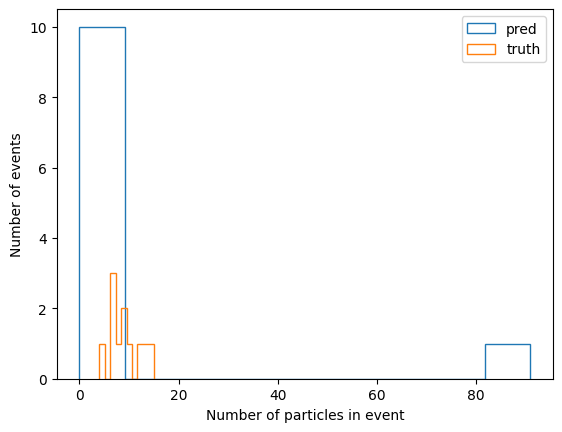

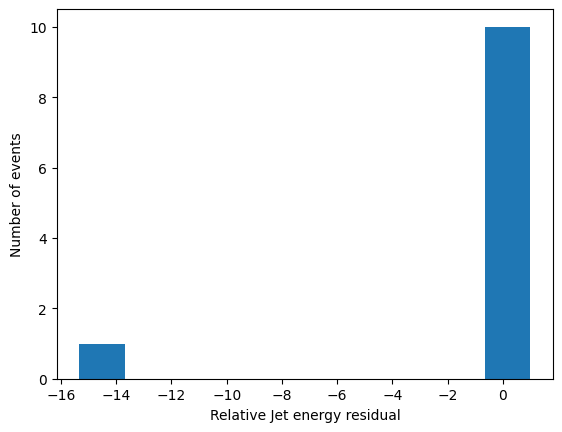

In [ ]:
#Jet metrics
reseta = []
resphi = []
relresE = []
nParicles_pred = []
nParicles_truth = []

for i in range(len(t_list)):
    # reseta.append(np.sum(t_list[i]['truthHitAssignedEta'])-np.sum(pred_list[i]['pred_eta']))
    # resphi.append(np.sum(t_list[i]['truthHitAssignedPhi'])-np.sum(pred_list[i]['pred_phi']))
    jet_E_truth = np.sum(np.unique(t_list[i]['truthHitAssignedEnergies']))
    #remove nan values
    help = np.unique(df[df['event_id']==i]['pred_energy'])
    jet_E_pred = np.sum(help[np.isnan(help)==False])
    relresE.append((jet_E_truth-jet_E_pred)/jet_E_truth)
    nParicles_pred.append(len(np.unique(df[df['event_id']==i]['pred_energy'])))
    nParicles_truth.append(len(np.unique(t_list[i]['truthHitAssignementIdx'])))
    
# plt.hist(reseta)
# plt.hist(resphi)

plt.hist(nParicles_pred, label='pred', histtype='step')
plt.hist(nParicles_truth, label='truth', histtype='step')
plt.ylabel('Number of events')
plt.xlabel('Number of particles in event')
plt.legend()
plt.show()

plt.hist(relresE)
plt.ylabel('Number of events')
plt.xlabel('Relative Jet energy residual')
plt.show()



## Neutral Particles E, phi, eta

3.1108510494232178
-2.6898539066314697
3.127699375152588
-3.1045305728912354
3.9383437037467957


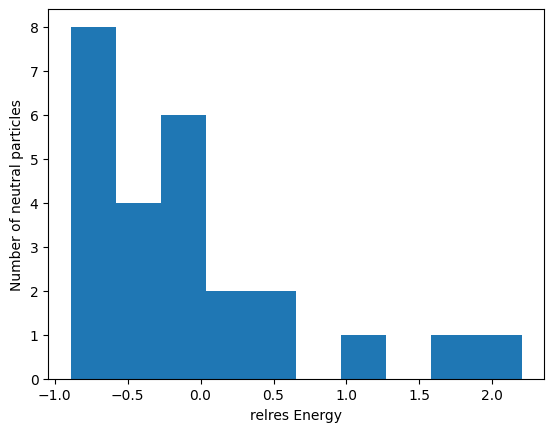

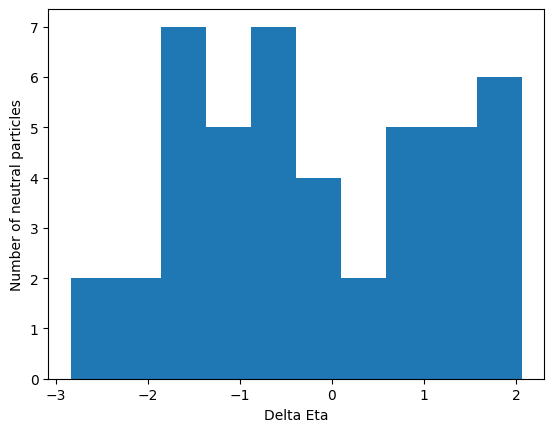

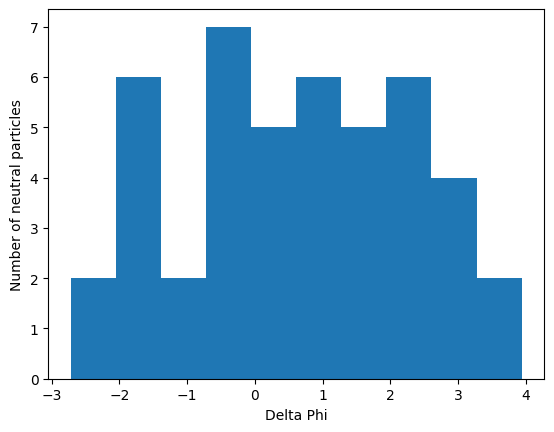

In [ ]:
mask_neutral = df['truthHitAssignedPIDs'].isin([22,130, 310, 311, 2112, -2112, 3122, -3122, 3322, -3322])

pt_pred = df[mask_neutral]['pred_energy']
pt_truth = df[mask_neutral]['truthHitAssignedEnergies']

help = df[mask_neutral]['pred_pos'].tolist()
#remove Nan
help = [x for x in help if str(x) != 'nan']
pos_pred_df = pd.DataFrame(help, columns=['cosphi', 'sinphi', 'eta'])

phi_pred = np.arctan2(pos_pred_df['sinphi'], pos_pred_df['cosphi'])
eta_pred = pos_pred_df['eta']

phi_truth = df[mask_neutral]['truthHitAssignedPhi']
eta_truth = df[mask_neutral]['truthHitAssignedEta']

relrespt = (pt_pred - pt_truth) / pt_truth
reseta = (eta_pred - eta_truth)
resphi = (phi_pred - phi_truth)

plt.hist(relrespt)
plt.xlabel('relres Energy')
plt.ylabel('Number of neutral particles')
plt.show()

plt.hist(reseta)
plt.xlabel('Delta Eta')
plt.ylabel('Number of neutral particles')
plt.show()

plt.hist(resphi)
plt.xlabel('Delta Phi')
plt.ylabel('Number of neutral particles')
plt.show()

## Charged Energy Resolution

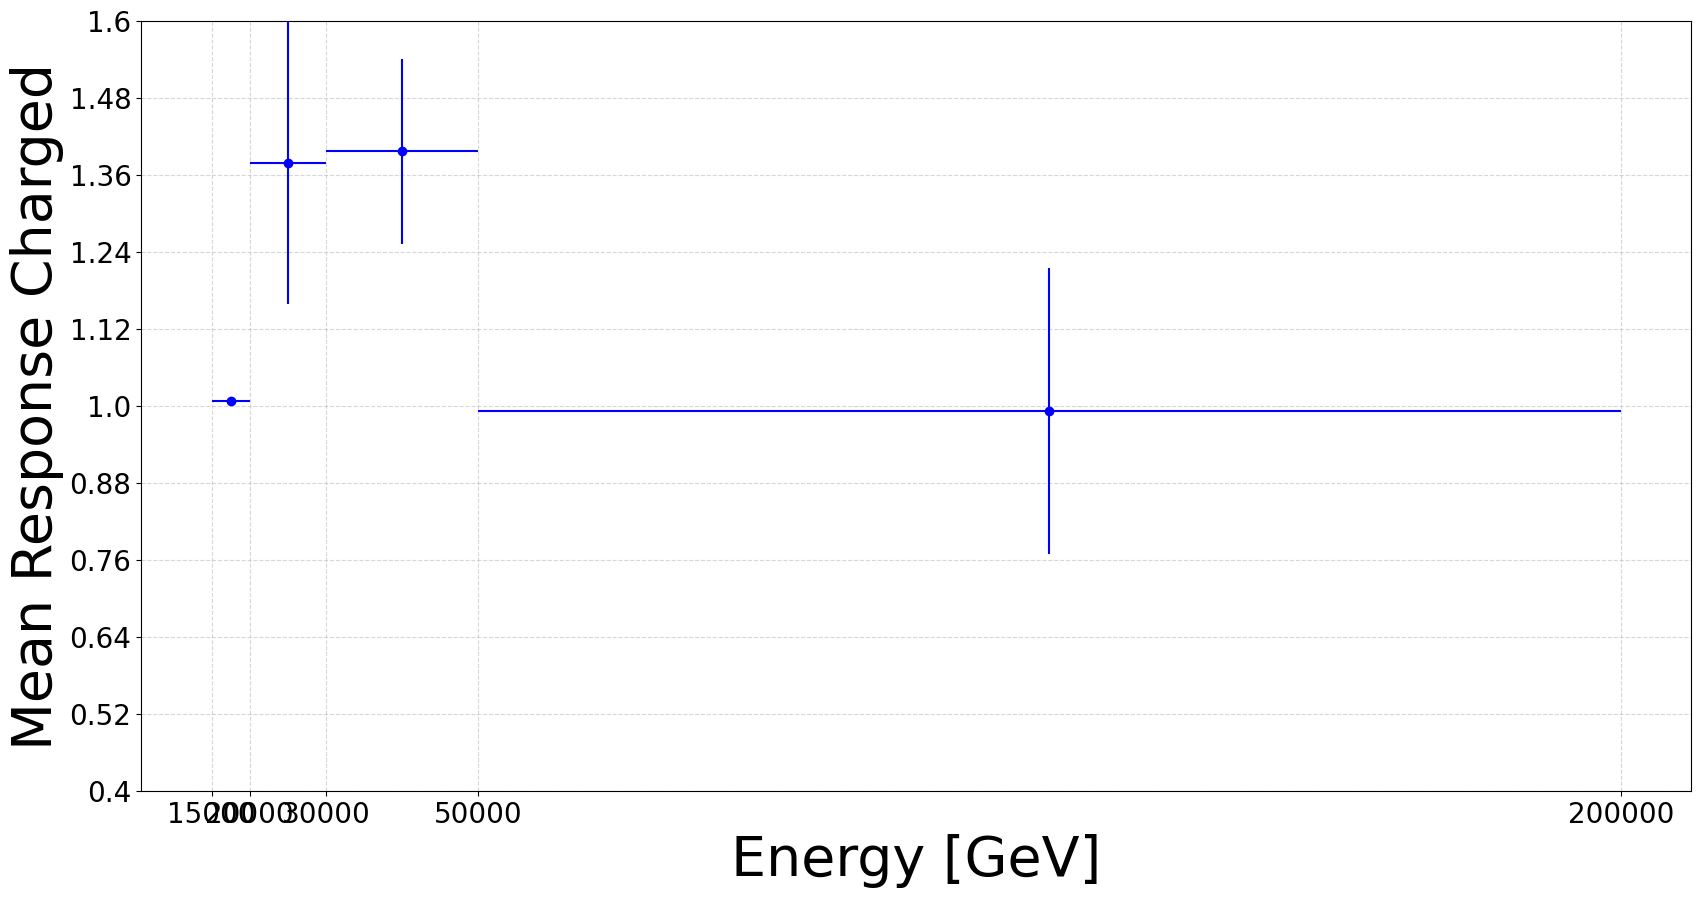

In [ ]:
def energy_resolution(df, bins=None):
    data, ratios = calc_resolution(df, bins)
    means = data['means']
    stddevs = data['stddevs']
    sigma_over_e = data['sigma_over_e']
    std_error = data['std_error']
    entries = data['entries']

    # make boxplots of the ratios for each bin
    fig, ax1 = plt.subplots(figsize=(20, 10))
    # ax1 and ax2 for histogram + mean
    # ax3 and ax4 for boxplot and stdddev
    binwidth = bins[1:] - bins[:-1]
    x = bins[:-1] + binwidth / 2
    xerr = binwidth / 2
    y = means
    yerr = std_error
    # plot x, y with error bars
    ax1.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', color='blue', zorder=2, label='Mean Response')
    # set xticks
    xticks = np.round(bins, 0).astype(int)
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xticks, fontsize=20)
    ymin = np.round(ax1.get_ylim()[0], 1)
    ymax = np.round(ax1.get_ylim()[1], 1)
    ydelta = max(1 - ymin, ymax - 1)
    ax1.set_ylim(1 - ydelta, 1 + ydelta)
    # set yticks to be evenlyt spaced around 1
    yticks = np.round(np.arange(1 - ydelta, 1 + ydelta, 0.02), 2)
    yticks = np.round(np.linspace(1 - ydelta, 1 + ydelta, 11), 2)
    ax1.set_yticks(yticks)
    ax1.set_yticklabels(yticks, fontsize=20)
    ax1.grid(alpha=0.5, linestyle='--')
    ax1.set_ylabel('Mean Response Charged', fontsize=40)
    ax1.set_xlabel('Energy [GeV]', fontsize=40)
    
    return fig

def calc_resolution(showers, bins, predstring='pred_energy'):
    """Calculate resolution for a given dataframe and energy bins."""
    has_truth = np.isnan(showers['truthHitAssignedEnergies']) == False
    has_pred = np.isnan(showers[predstring]) == False
    matched = np.logical_and(has_truth, has_pred)

    all_ratios = []
    means = []
    stddevs = []
    sigma_over_e = []
    std_error = []
    entries = []

    for i in range(len(bins) - 1):
        mask_truth_bin = np.logical_and(
            showers['truthHitAssignedEnergies'] >= bins[i],
            showers['truthHitAssignedEnergies'] < bins[i + 1])
        mask_bin = np.logical_and(mask_truth_bin, matched)
        ratios = showers[predstring][mask_bin] / showers['truthHitAssignedEnergies'][mask_bin]
        all_ratios.append(ratios)
        means.append(np.mean(all_ratios[-1]))
        stddevs.append(np.std(all_ratios[-1]))
        sigma_over_e.append(stddevs[-1] / means[-1])
        std_error.append(stddevs[-1] / np.sqrt(len(all_ratios[-1])))
        entries.append(len(all_ratios[-1]))

    data = pd.DataFrame({
        "means": np.array(means),
        "stddevs": np.array(stddevs),
        "sigma_over_e": np.array(sigma_over_e),
        "std_error": np.array(std_error),
        "entries": np.array(entries),
    })

    return data, all_ratios

energy_bins = np.array([15,20,30,50,200])*1000
charged_mask = df['truthHitAssignedPIDs'].isin([11,-11,13,-13,211,-211,321,-321,2212,-2212,3112,-3112,3222,-3222,3312,-3312])
fig=energy_resolution(df[charged_mask], bins=energy_bins)